# Implementing Generative Adversarial Network (GAN)

In this notebook I implement a [GAN](https://arxiv.org/pdf/1406.2661.pdf). It consists of two parts, a generator and a discriminator. These two networks compete against each other, each helping the other to increase in accuracy.

More precisely the discriminator is trained to detect fake images and the generator is trained to create "real" images.

The generator provides the "fake" training data for the discriminator with the dataset providing the "real" training data.

Simultaneously the generator is trying to produce images the discriminator thinks are real with the discriminator acting as a loss function for the generator

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

import time

BS=128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Get Data

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=BS, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BS, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 10548027.66it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173673.35it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3262430.80it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21854531.37it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## Create Generative Model

In [ ]:
class GenNet(nn.Module):
    def __init__(self):
        super(GenNet, self).__init__()
        self.fc1 = nn.Linear(100,3136)
        self.bn1 = nn.BatchNorm1d(1)
        self.conv1 = nn.ConvTranspose2d(64, 128, (5,5),padding=2,output_padding=1, stride = 2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2 = nn.ConvTranspose2d(128, 1, (5,5),padding=2,output_padding=1,stride = 2)

    def forward(self, x):
        x.reshape(-1,1,100)
        x = self.fc1(x)
        x = x.reshape(-1,1,3136)
        x = self.bn1(x)
        x = F.elu(x)
        x = x.reshape(-1,64,7,7)
        x = self.bn2(self.conv1(x))
        x = F.elu(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        x.reshape(-1,28,28)
        return x

## Create Classifier Model

In [ ]:
class ClassNet(nn.Module):
    def __init__(self):
        super(ClassNet, self).__init__()
        #2 convolutional layers followed by 3 FC layers
        self.conv1 = nn.Conv2d(1, 64, (5,5),padding=2, stride = 2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, (7,7), padding=3, stride = 2)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(6272, 128)
        #first output is discriminator: 1 for real, 0 for fake
        #next 10 indicate which digit the discriminator thinks it is
        self.fc2 = nn.Linear(128, 1)


    def forward(self, x):
        x.reshape(-1,1,28,28)
        x = self.bn1(self.conv1(x))
        x = F.elu(x)

        x = self.bn2(self.conv2(x))
        x = F.elu(x)

        x = x.reshape(-1,1,6272)
        x = F.elu(self.fc1(x))

        x = F.elu(self.fc2(x))

        return x

## Training

In [ ]:
classifierModel = ClassNet()
generatorModel = GenNet()

def mse_loss(output,target):
  return ((output-target)**2).mean()
loss_fn = mse_loss
learning_rate=0.001



In [ ]:
classifierModel.to(device)
generatorModel.to(device)


generatorOptim = optim.Adam(generatorModel.parameters(), lr=learning_rate)
classifierOptim = optim.Adam(classifierModel.parameters(), lr=learning_rate)
def train_one_epoch(learning_rate=0.01):
      for inputs, labels in train_dataloader:
            #discriminator training
            classifierOptim.zero_grad()

            inputs_fake = torch.randn((128,100)).to(device)
            outputs_real = classifierModel(inputs.to(device))
            outputs_fake = classifierModel(generatorModel(inputs_fake).reshape(-1,1,28,28))
            lossReal = loss_fn(outputs_real, torch.ones(BS).to(device))
            lossFake = loss_fn(outputs_fake, torch.zeros(BS).to(device))
            #average loss on real and fake data
            loss = (lossFake+lossReal)/2
            loss.backward()
            classifierOptim.step()
            #generator training
            classifierOptim.zero_grad()
            generatorOptim.zero_grad()
            inputs_fake = torch.randn((128,100)).to(device)

            outputs_fake = classifierModel(generatorModel(inputs_fake).reshape(-1,1,28,28))
            #as we want the discriminator to think our images are real, we set targets as ones
            loss = loss_fn(outputs_fake, torch.ones(BS).to(device))
            loss.backward()
            generatorOptim.step()



In [ ]:
for _ in range(10):
  train_one_epoch()

## Results



Top row are "fake" images, bottom row are "real"

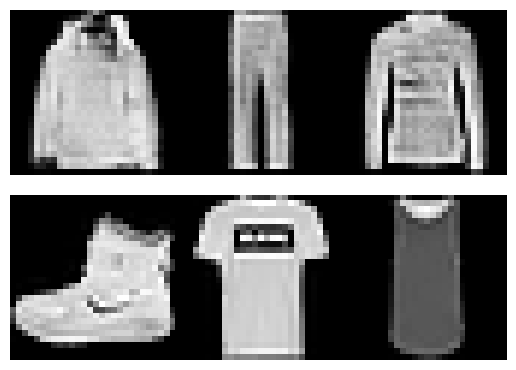

In [ ]:
generatorModel.to('cpu')
row_size=3
y = generatorModel.forward(torch.randn((row_size,100)).reshape(-1,1,100))

generatorModel.to(device)


fig, axs = plt.subplots(2, row_size)
for i in range(len(axs[0])):
  axs[0,i].imshow(y[i].resize(28,28).detach().numpy(),cmap='gray',vmin=0,vmax=1)
  axs[1,i].imshow(training_data[i][0].resize(28,28),cmap='gray',vmin=0,vmax=1)
  axs[0,i].axis('off')
  axs[1,i].axis('off')

fig.subplots_adjust(wspace=0, hspace=0)
